In [18]:
import torch
#from torchviz import make_dot
from torchvision import datasets
from torch import optim
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import requests
#import cv2


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
# data proccesing
df = pd.read_csv("/content/sample_data/train.csv")
# df = dff.dropna(axis=1)
x = df.drop(["target" , "ID_code"] , axis=1)
y = df["target"]



x_train , x_test , y_train , y_test = train_test_split(x ,
                                                       y ,
                                                       test_size=.2 ,
                                                       random_state=42 ,
                                                       stratify=y)
# scaling data
x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)



In [20]:
class CustomDataset(Dataset):
  def __init__(self , data , target):
    self.data = torch.tensor(data , dtype=torch.float32)
    self.target = torch.tensor(target , dtype=torch.float32)

  def __getitem__(self , ix):
    return self.data[ix] , self.target[ix]

  def __len__(self):
    return len(self.data)

train_dataset = CustomDataset(x_train , y_train.values.reshape(-1 , 1))
val_dataset = CustomDataset(x_test , y_test.values.reshape(-1 , 1))

train_loader = DataLoader(train_dataset , batch_size=32 , shuffle=True)
val_loader = DataLoader(val_dataset , batch_size=32 , shuffle=False)

In [21]:
class ManualClassification(nn.Module):
  def __init__(self , input_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim , 200 , bias=True)
    self.bn1 = nn.BatchNorm1d(200)
    self.fc2 = nn.Linear(200 , 100)
    self.bn2 = nn.BatchNorm1d(100)
    self.fc3 = nn.Linear(100 , 50)
    self.bn3 = nn.BatchNorm1d(50)
    self.fc4 = nn.Linear(50 , 25)
    self.bn4 = nn.BatchNorm1d(25)
    self.fc5 = nn.Linear(25 , 1)
    self.relu = nn.ReLU()


    self.drop1 = nn.Dropout(p=.5)
    self.drop2 = nn.Dropout(p=.5)
    self.drop3 = nn.Dropout(p=.5)
    self.drop4 = nn.Dropout(p=.5)


  def forward(self , x):
    x = self.relu(self.bn1(self.fc1(x)))
    x = self.drop1(x)
    x = self.relu(self.bn2(self.fc2(x)))
    x = self.drop2(x)
    x = self.relu(self.bn3(self.fc3(x)))
    x = self.drop3(x)
    x = self.relu(self.bn4(self.fc4(x)))
    x = self.drop4(x)
    x = self.fc5(x)
    return x

In [22]:
for xb, yb in train_loader:
    print("Batch X:", xb.shape)
    print("Batch Y:", yb.shape)
    break

Batch X: torch.Size([32, 200])
Batch Y: torch.Size([32, 1])


In [33]:
def accuracy(outputs , targets):
    probs = torch.sigmoid(outputs)
    preds = (probs >= 0.5).float()
    correct = (preds == targets).sum().item()
    return correct / targets.size(0)

def train(model , dataloader  , optimizer , loss_fn):
  model.train()
  total_loss = 0.0
  total_acc = 0.0
  for inputs , targets in dataloader:
    inputs , targets = inputs.to(device) , targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs , targets)
    loss.backward()
    optimizer.step()
    total_loss += loss.detach().cpu().item()
    total_acc += accuracy(outputs , targets)
  return total_loss / len(dataloader) , total_acc / len(dataloader)


def validate(model , dataloader , loss_fn):
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  for inputs , targets in dataloader:
    inputs , targets = inputs.to(device) , targets.to(device)
    with torch.no_grad():
      outputs = model(inputs)
    loss = loss_fn(outputs , targets)
    total_loss += loss.detach().cpu().item()
    total_acc += accuracy(outputs , targets)
  return total_loss / len(dataloader) , total_acc / len(dataloader)


Epoch 1/50, Train Loss: 0.3270, Validation Loss: 0.2740, Train Accuracy: 0.8954, Validation Accuracy: 0.9008
Epoch 2/50, Train Loss: 0.2664, Validation Loss: 0.2603, Train Accuracy: 0.9009, Validation Accuracy: 0.9008
Epoch 3/50, Train Loss: 0.2551, Validation Loss: 0.2524, Train Accuracy: 0.9008, Validation Accuracy: 0.9008
Epoch 4/50, Train Loss: 0.2466, Validation Loss: 0.2400, Train Accuracy: 0.9008, Validation Accuracy: 0.9008
Epoch 5/50, Train Loss: 0.2338, Validation Loss: 0.2283, Train Accuracy: 0.9008, Validation Accuracy: 0.9008
Epoch 6/50, Train Loss: 0.2204, Validation Loss: 0.2160, Train Accuracy: 0.9008, Validation Accuracy: 0.9010
Epoch 7/50, Train Loss: 0.2105, Validation Loss: 0.2054, Train Accuracy: 0.9105, Validation Accuracy: 0.9104
Epoch 8/50, Train Loss: 0.1990, Validation Loss: 0.1956, Train Accuracy: 0.9149, Validation Accuracy: 0.9182
Epoch 9/50, Train Loss: 0.1918, Validation Loss: 0.1866, Train Accuracy: 0.9188, Validation Accuracy: 0.9226
Epoch 10/50, Train 

/tmp/ipython-input-2591312550.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in  plt.gca().get_yticks()])


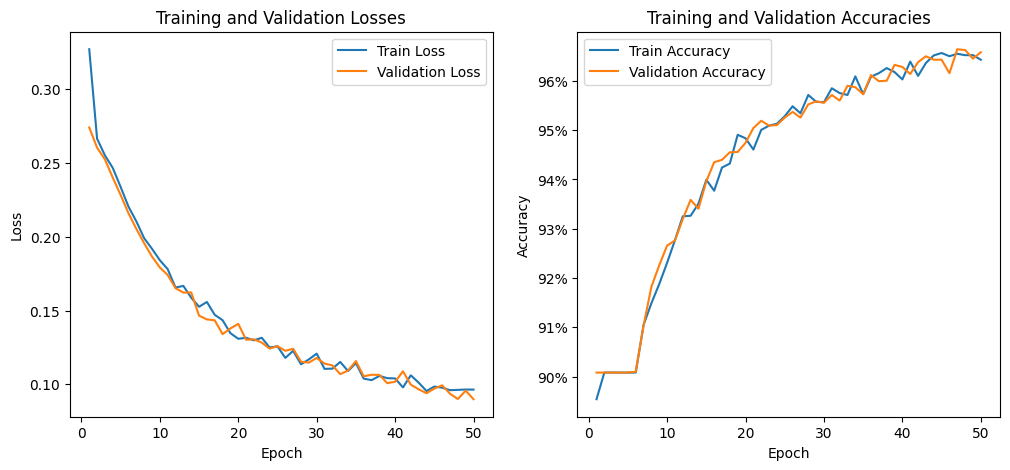

In [34]:
lr = 1e-2
input_dim = x_train.shape[1]
model = ManualClassification(input_dim).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters() , lr=lr)
epoches = 50
train_acces, val_acces = [], []
train_losses, val_losses = [], []

for i in range(epoches):
  train_loss , train_acc = train(model , train_loader , optimizer , loss_fn)
  train_losses.append(train_loss) , train_acces.append(train_acc)
  val_loss , val_acc = train(model , train_loader , optimizer , loss_fn)
  val_losses.append(val_loss) , val_acces.append(val_acc)

  print(f"Epoch {i+1}/{epoches}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
        f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, epoches + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epoches + 1), train_acces, label='Train Accuracy')
plt.plot(range(1, epoches + 1), val_acces, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in  plt.gca().get_yticks()])
plt.legend()

plt.show()